In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from DAFD.rv_study.rv_utils import *
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from tqdm import tqdm
from DAFD.helper_scripts.ModelHelper import ModelHelper
from sklearn.feature_selection import f_regression

Using TensorFlow backend.


regime classifier
Loading classifier
Train accuracy: 0.9887387387387387

Regression model generation_rate2
Loading Regressor
R square (R^2) for Train:                 0.987384

Regression model droplet_size2
Loading Regressor
R square (R^2) for Train:                 0.983142

Regression model generation_rate1
Loading Regressor
R square (R^2) for Train:                 0.965872

Regression model droplet_size1
Loading Regressor
R square (R^2) for Train:                 0.953238



In [2]:
# Load datasets to be used for analysis
chips = pd.read_csv("data/20210420_versatility_results_dripping.csv")
all_results = pd.read_csv("data/20210419_all_data_working.csv")

# Filter results manually
all_results = all_results.loc[all_results["regime"] == 1, :]
all_results = all_results.loc[all_results["diff"] < 50, :]
chips = chips.loc[chips["score"] != -1,:]
chips = chips.sort_values("score")

LOWEST 0.000004
HIGHEST 36810.615724


Text(0, 0.5, 'Generation Rate (Hz)')

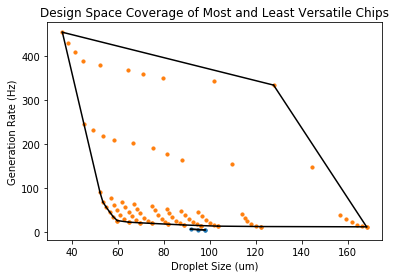

In [3]:
# Get Most and Least versatile devices and compare plots
highest_results = all_results.loc[all_results["chip_num"]==chips.iloc[-1, 0], :]
lowest_results = all_results.loc[all_results["chip_num"]==chips.iloc[0, 0], :]

print("LOWEST %f" % chips.head(1)["score"])
print("HIGHEST %f" % chips.tail(1)["score"])


for x in [lowest_results, highest_results]:
    sizes = x["droplet_size"].tolist()
    rates = x["generation_rate"].tolist()
    points = np.array([[sizes[i], rates[i]] for i in range(len(sizes))])
    hull = ConvexHull(points)
    plt.scatter(points[:,0], points[:,1], s=10)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
        
plt.title("Design Space Coverage of Most and Least Versatile Chips")
plt.xlabel("Droplet Size (um)")
plt.ylabel("Generation Rate (Hz)")
#plt.savefig("VersatilityExtremes_Compare.png")

*Main Effect Analysis*

In [4]:
mean_score = chips["score"].mean()
mean_size_score = chips["size_score"].mean()
mean_rate_score = chips["rate_score"].mean()

In [5]:
meff_cols = ['aspect_ratio', 'expansion_ratio',
       'normalized_oil_inlet', 'normalized_orifice_length',
       'normalized_water_inlet', 'orifice_size']#, "capillary_number", "flow_rate_ratio"]

meff_vals = {}
for col in meff_cols:
    sweep_range = all_results[col].unique()
    size_score_avgs = []
    rate_score_avgs = []
    score_avgs = []
    size_score_std = []
    rate_score_std = []
    score_std = []
    
    
    
    for val in sweep_range:
        #size_avgs.append(size_normalized[all_results[col] == val].mean())
        size_score_avgs.append(chips.loc[chips[col] == val, "size_score"].mean())
        rate_score_avgs.append(chips.loc[chips[col] == val, "rate_score"].mean())
        score_avgs.append(chips.loc[chips[col] == val, "score"].mean())
        size_score_std.append(chips.loc[chips[col] == val, "size_score"].std())
        rate_score_std.append(chips.loc[chips[col] == val, "rate_score"].std())
        score_std.append(chips.loc[chips[col] == val, "score"].std())

        
        #meff_vals[col] = {"range": sweep_range, "size_averages": size_avgs, "rate_averages": rate_avgs}
    meff_vals[col] = {"range": sweep_range, "size_score_avgs": size_score_avgs, "rate_score_avgs": rate_score_avgs, "score_avgs": score_avgs,
                      "size_score_std": size_score_std, "rate_score_std":rate_score_std, "score_std":score_std}
    

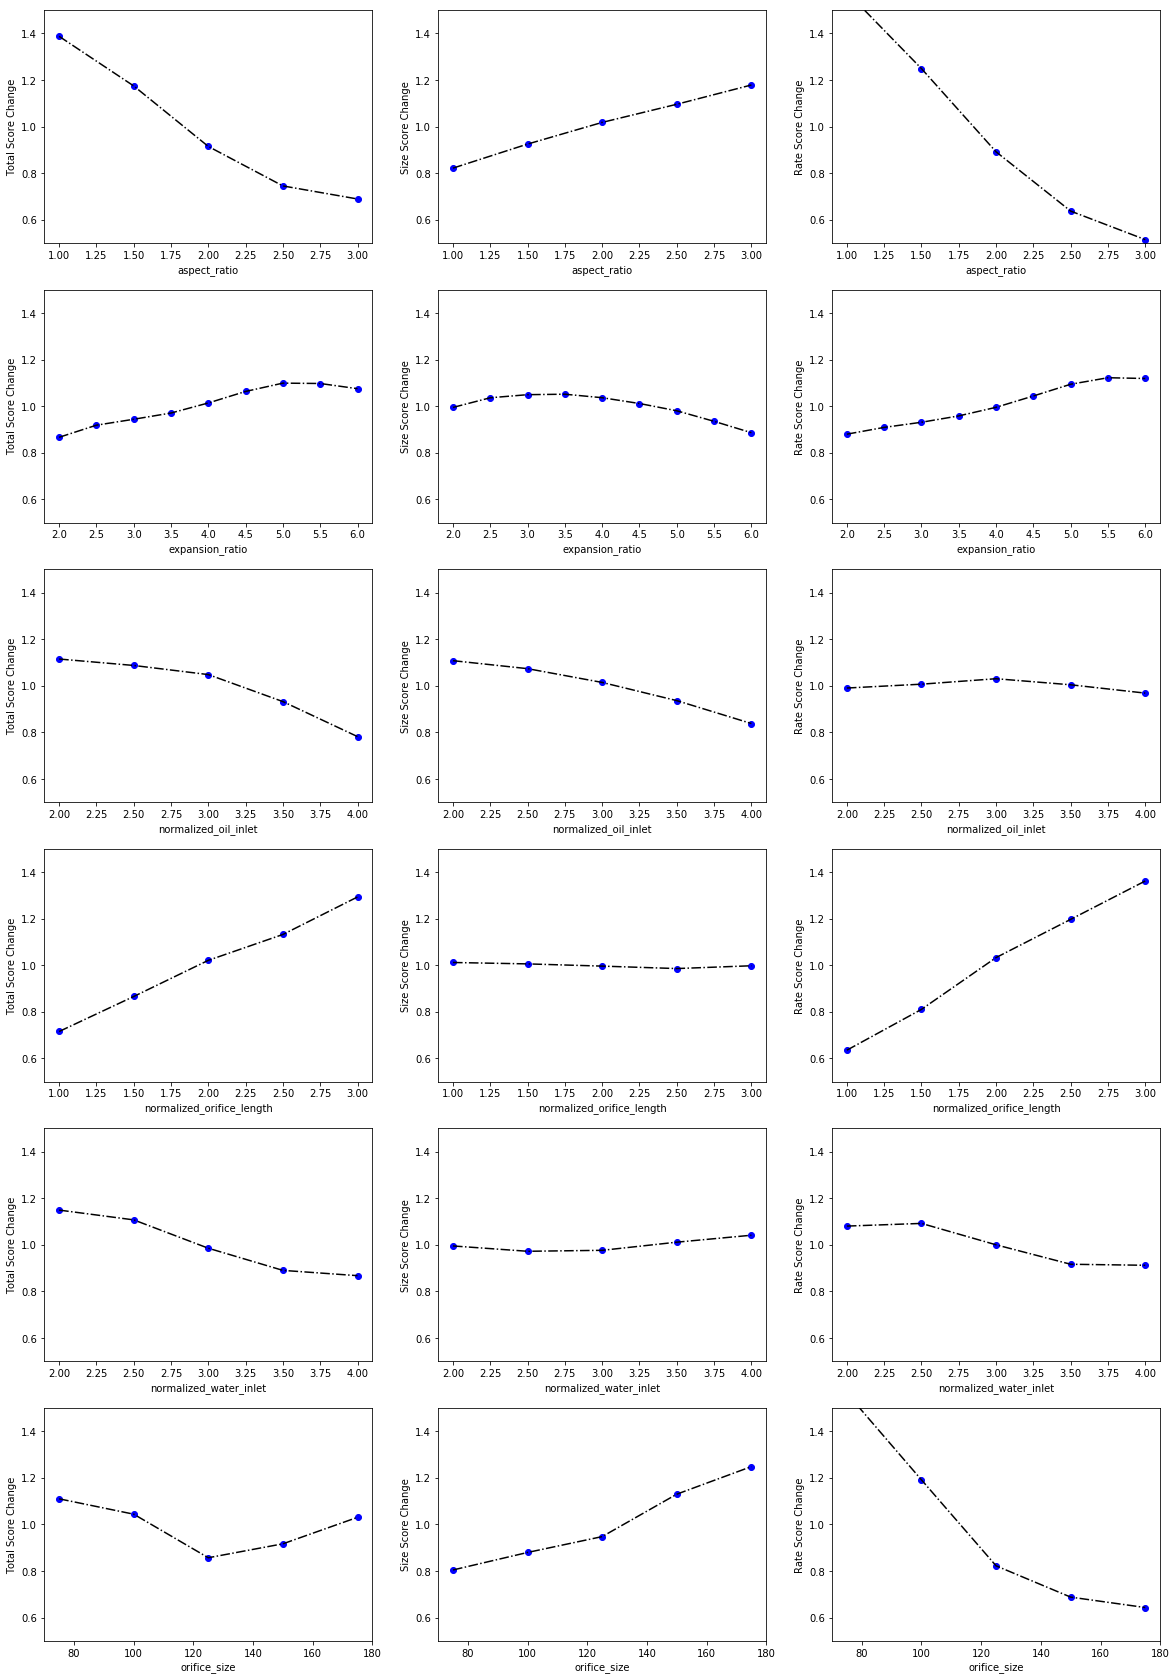

In [6]:
# Plot Main Effect Analysis Results
fig, axs = plt.subplots(6,3, figsize=[20,30])
for i, param in enumerate(meff_vals.keys()):
    param_range = meff_vals[param]["range"]
    score_normed =  meff_vals[param]["score_avgs"]/mean_score
    size_score_normed = meff_vals[param]["size_score_avgs"]/mean_size_score
    rate_score_normed = meff_vals[param]["rate_score_avgs"]/mean_rate_score
    
    score_std_normed =  meff_vals[param]["score_std"]/mean_score
    size_score_std_normed = meff_vals[param]["size_score_std"]/mean_size_score
    rate_score_std_normed = meff_vals[param]["rate_score_std"]/mean_rate_score
    
    axs[i][0].plot(param_range, score_normed, "bo")
    axs[i][0].plot(param_range, score_normed, "k-.")
    axs[i][0].set_xlabel(param)
    axs[i][0].set_ylabel("Total Score Change")
    axs[i][0].set_ylim([0.5, 1.5])
        
    axs[i][1].plot(param_range, size_score_normed, "bo")
    axs[i][1].plot(param_range, size_score_normed, "k-.")
    axs[i][1].set_xlabel(param)
    axs[i][1].set_ylabel("Size Score Change")
    axs[i][1].set_ylim([0.5, 1.5])
    
    axs[i][2].plot(param_range, rate_score_normed, "bo")
    axs[i][2].plot(param_range, rate_score_normed, "k-.")
    axs[i][2].set_xlabel(param)
    axs[i][2].set_ylabel("Rate Score Change")
    axs[i][2].set_ylim([0.5, 1.5])
    
#plt.savefig('20210420_versatility_dripping.png')

Run F-regression to quantify versatility score sensitivity to parameter changes

In [7]:
X = np.zeros([chips.shape[0], len(meff_cols)])
for i, col in enumerate(meff_cols):
    X[:,i] = chips.loc[:, col]
Y = chips.loc[:, "score"]

In [8]:
f_test_all, _ = f_regression(X,chips.loc[:, "score"])
f_test_size, _ = f_regression(X,chips.loc[:, "size_score"])
f_test_rate, _ = f_regression(X,chips.loc[:, "rate_score"])


In [9]:
F = pd.DataFrame([f_test_all, f_test_size, f_test_rate], columns=meff_cols, index=["score", "size_score", "rate_score"])